In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
sys.path.append('../problems/')
import model_vis
import models
import generation_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint
from factorization import Factorization

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [4]:
device = torch.device('cuda')

In [5]:
base_path = '../models/factorization/2^22/scaled/'

In [6]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/factorization/2^22/scaled/checkpoints/389150_0.0727.pt


In [7]:
args = checkpoint['args']

In [8]:
problem = Factorization(args)

In [9]:
t = problem.get_tokenizer()

In [10]:
args.keys()

dict_keys(['data', 'problem_type', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [11]:
model = models.Seq2SeqModel(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Seq2SeqModel(
  (src_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 256)
  )
  (tgt_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 256)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-9): 10 x TransformerEncoderLayer(
          (self_attn): MultiHeadRelativeAttention(
            (w_q): Linear(in_features=256, out_features=256, bias=False)
            (w_k): Linear(in_features=256, out_features=256, bias=False)
            (w_v): Linear(in_features=256, out_features=256, bias=False)
            (out_proj): Linear(in_features=256, out_features=256, bias=False)
            (pe_mod): PositionalEncoding(
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (w_k_pos): Linear(in_features=256, out_features=256, bias=False)
          )
          (linear1): Linear(in_features=256,

In [12]:
example_row = problem.solve(54312, model, device, args['model_args']['max_decode_size'], n_beams = 1, temperature=1, return_type='df')

In [13]:
example_row

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,54312,"[[SOS], 2, 0, 10, 12, [EOS]]",0,-0.000009,[SOS] 2 * 2 * 2 * 3 * 1 1 * 2 13 [EOS],"[2, 2, 2, 3, 31, 73]",54312,6,6,1.0,True,True,False,False,[SOS] 2 * 2 * 2 * 3 * 1 1 * 2 13 [EOS],"[2, 2, 2, 3, 31, 73]",6,2


In [14]:
example_row['correct_product'].any()

True

In [15]:
example_row['correct_factorization'].any()

True

In [30]:
input = t.encode(problem.form_input(example_row['input_num'].iloc[0], args['data']['base']))
tgt = t.encode(example_row['pred_str'].iloc[0].replace('_', '').strip().split(' '))

In [31]:
input

[33, 2, 0, 10, 12, 32]

In [32]:
tgt

[33, 2, 30, 2, 30, 2, 30, 3, 30, 1, 1, 30, 2, 13, 32]

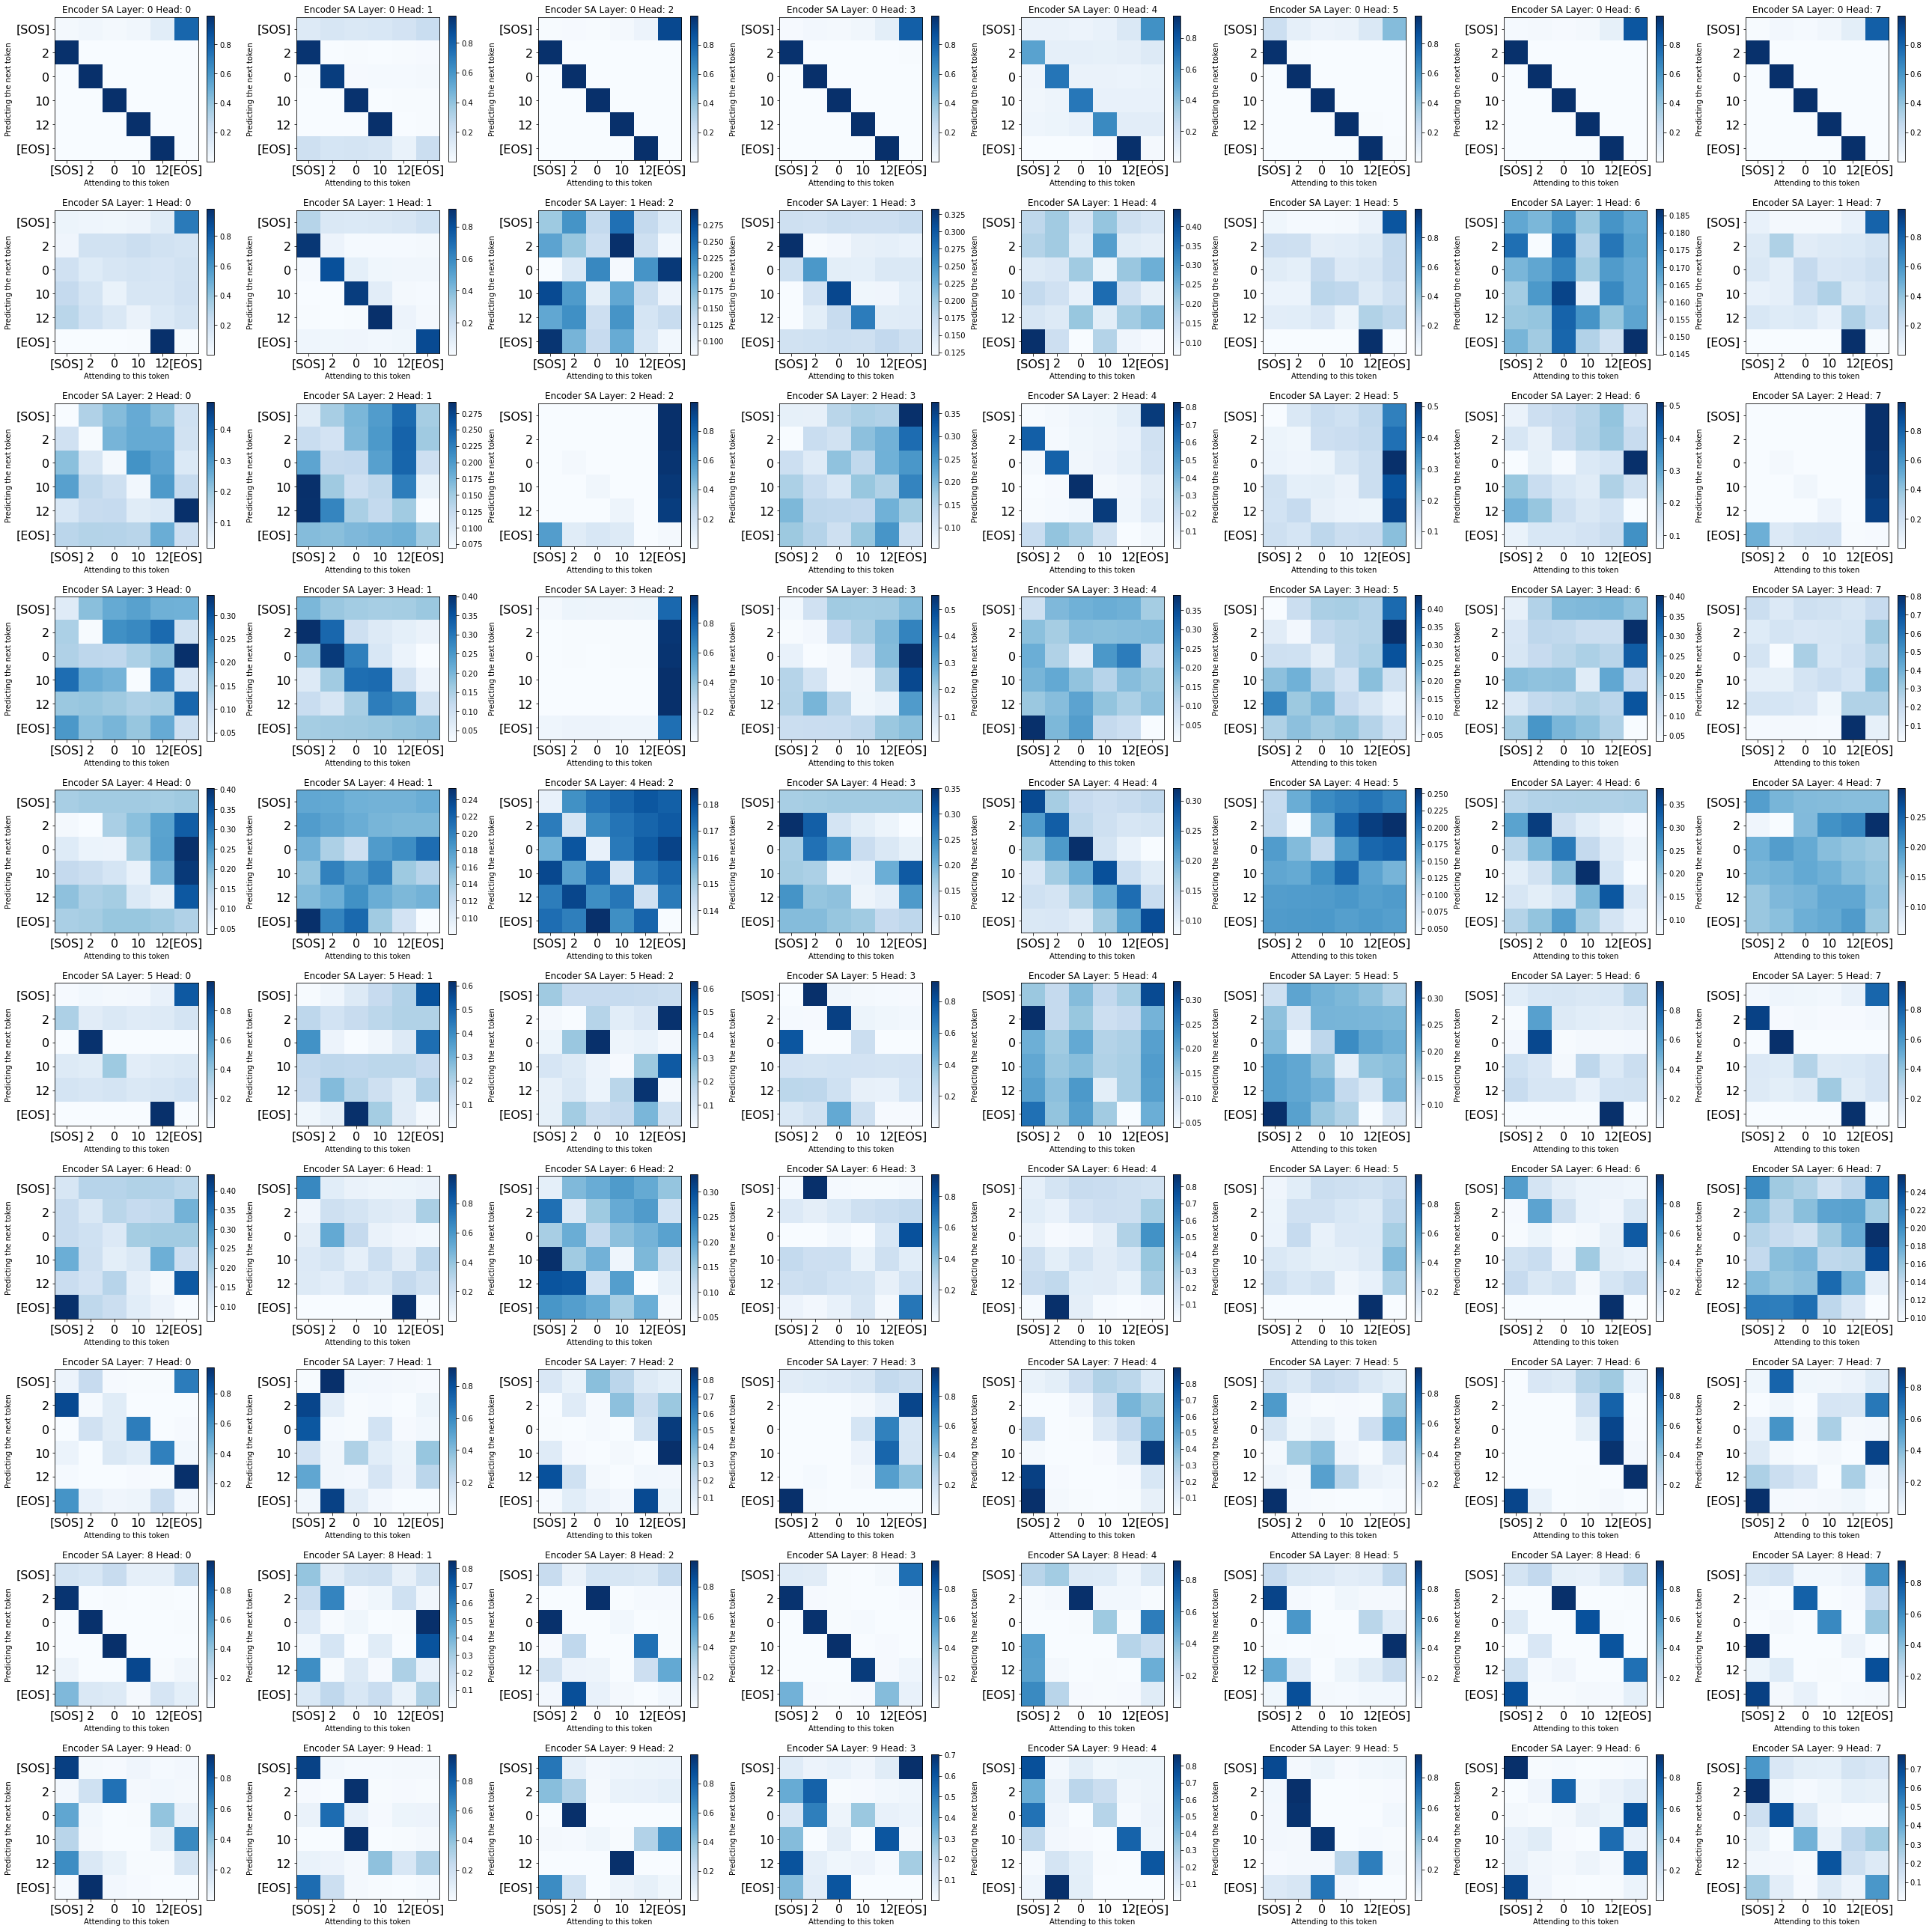

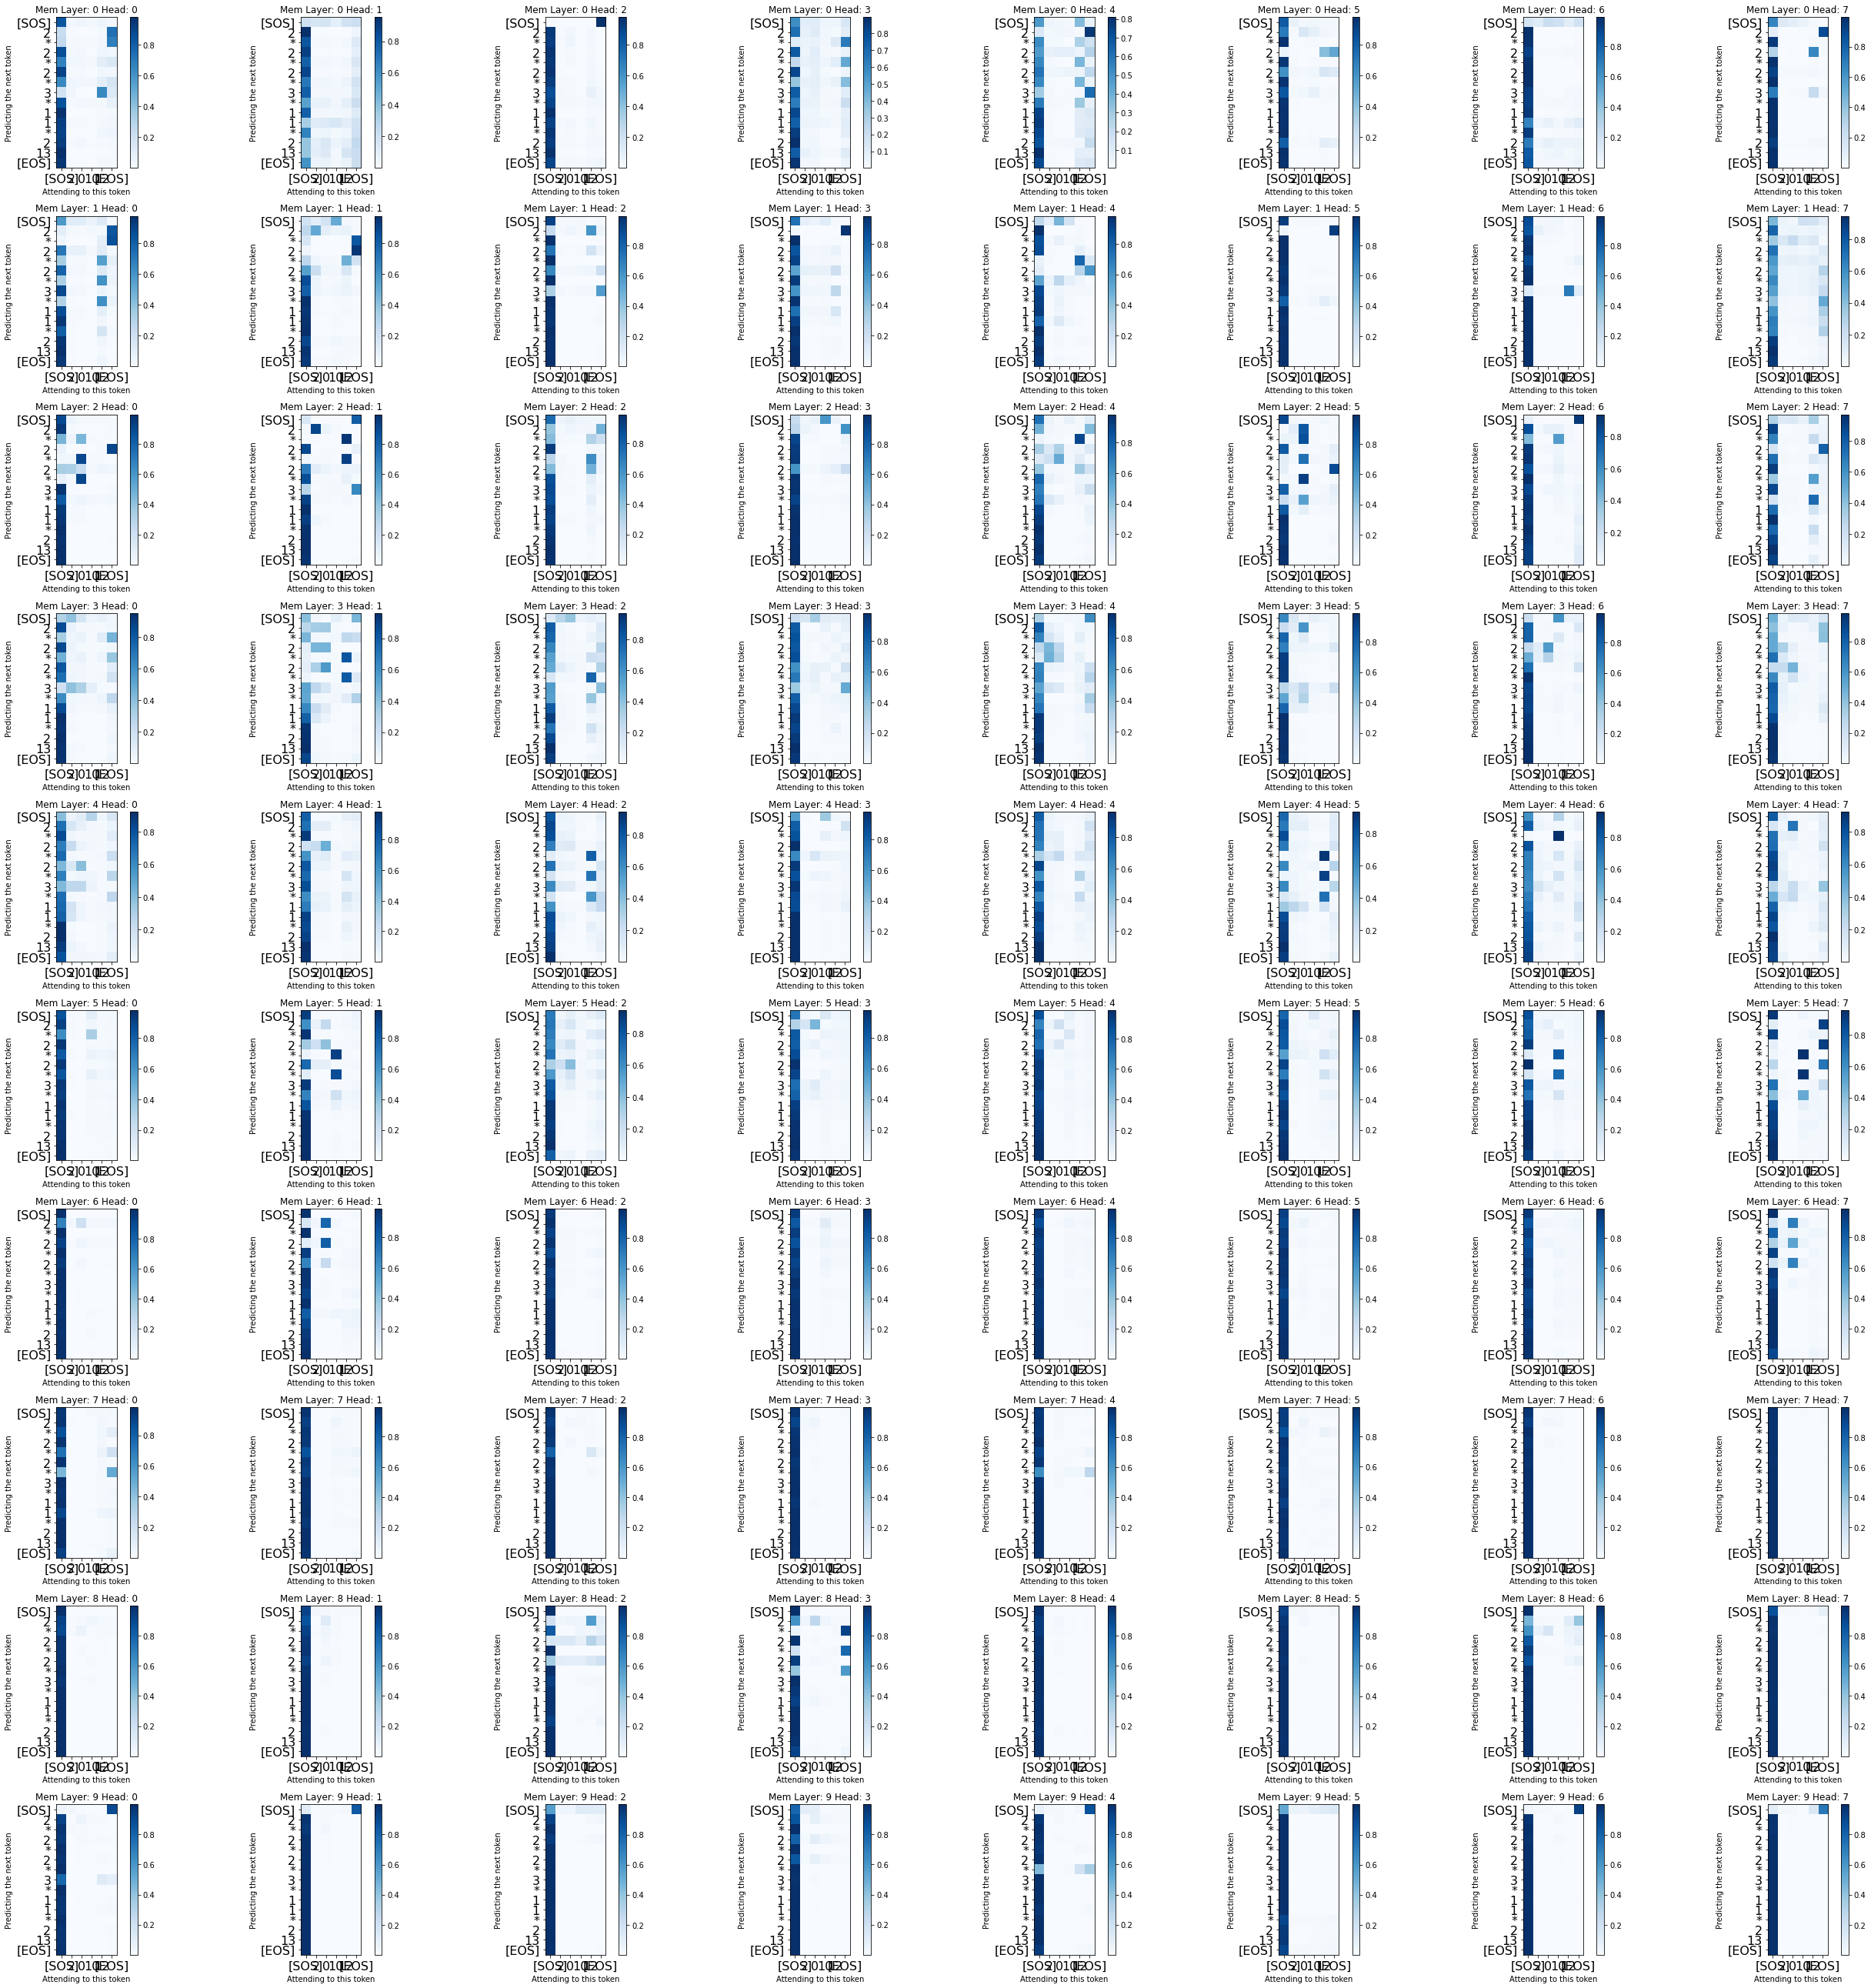

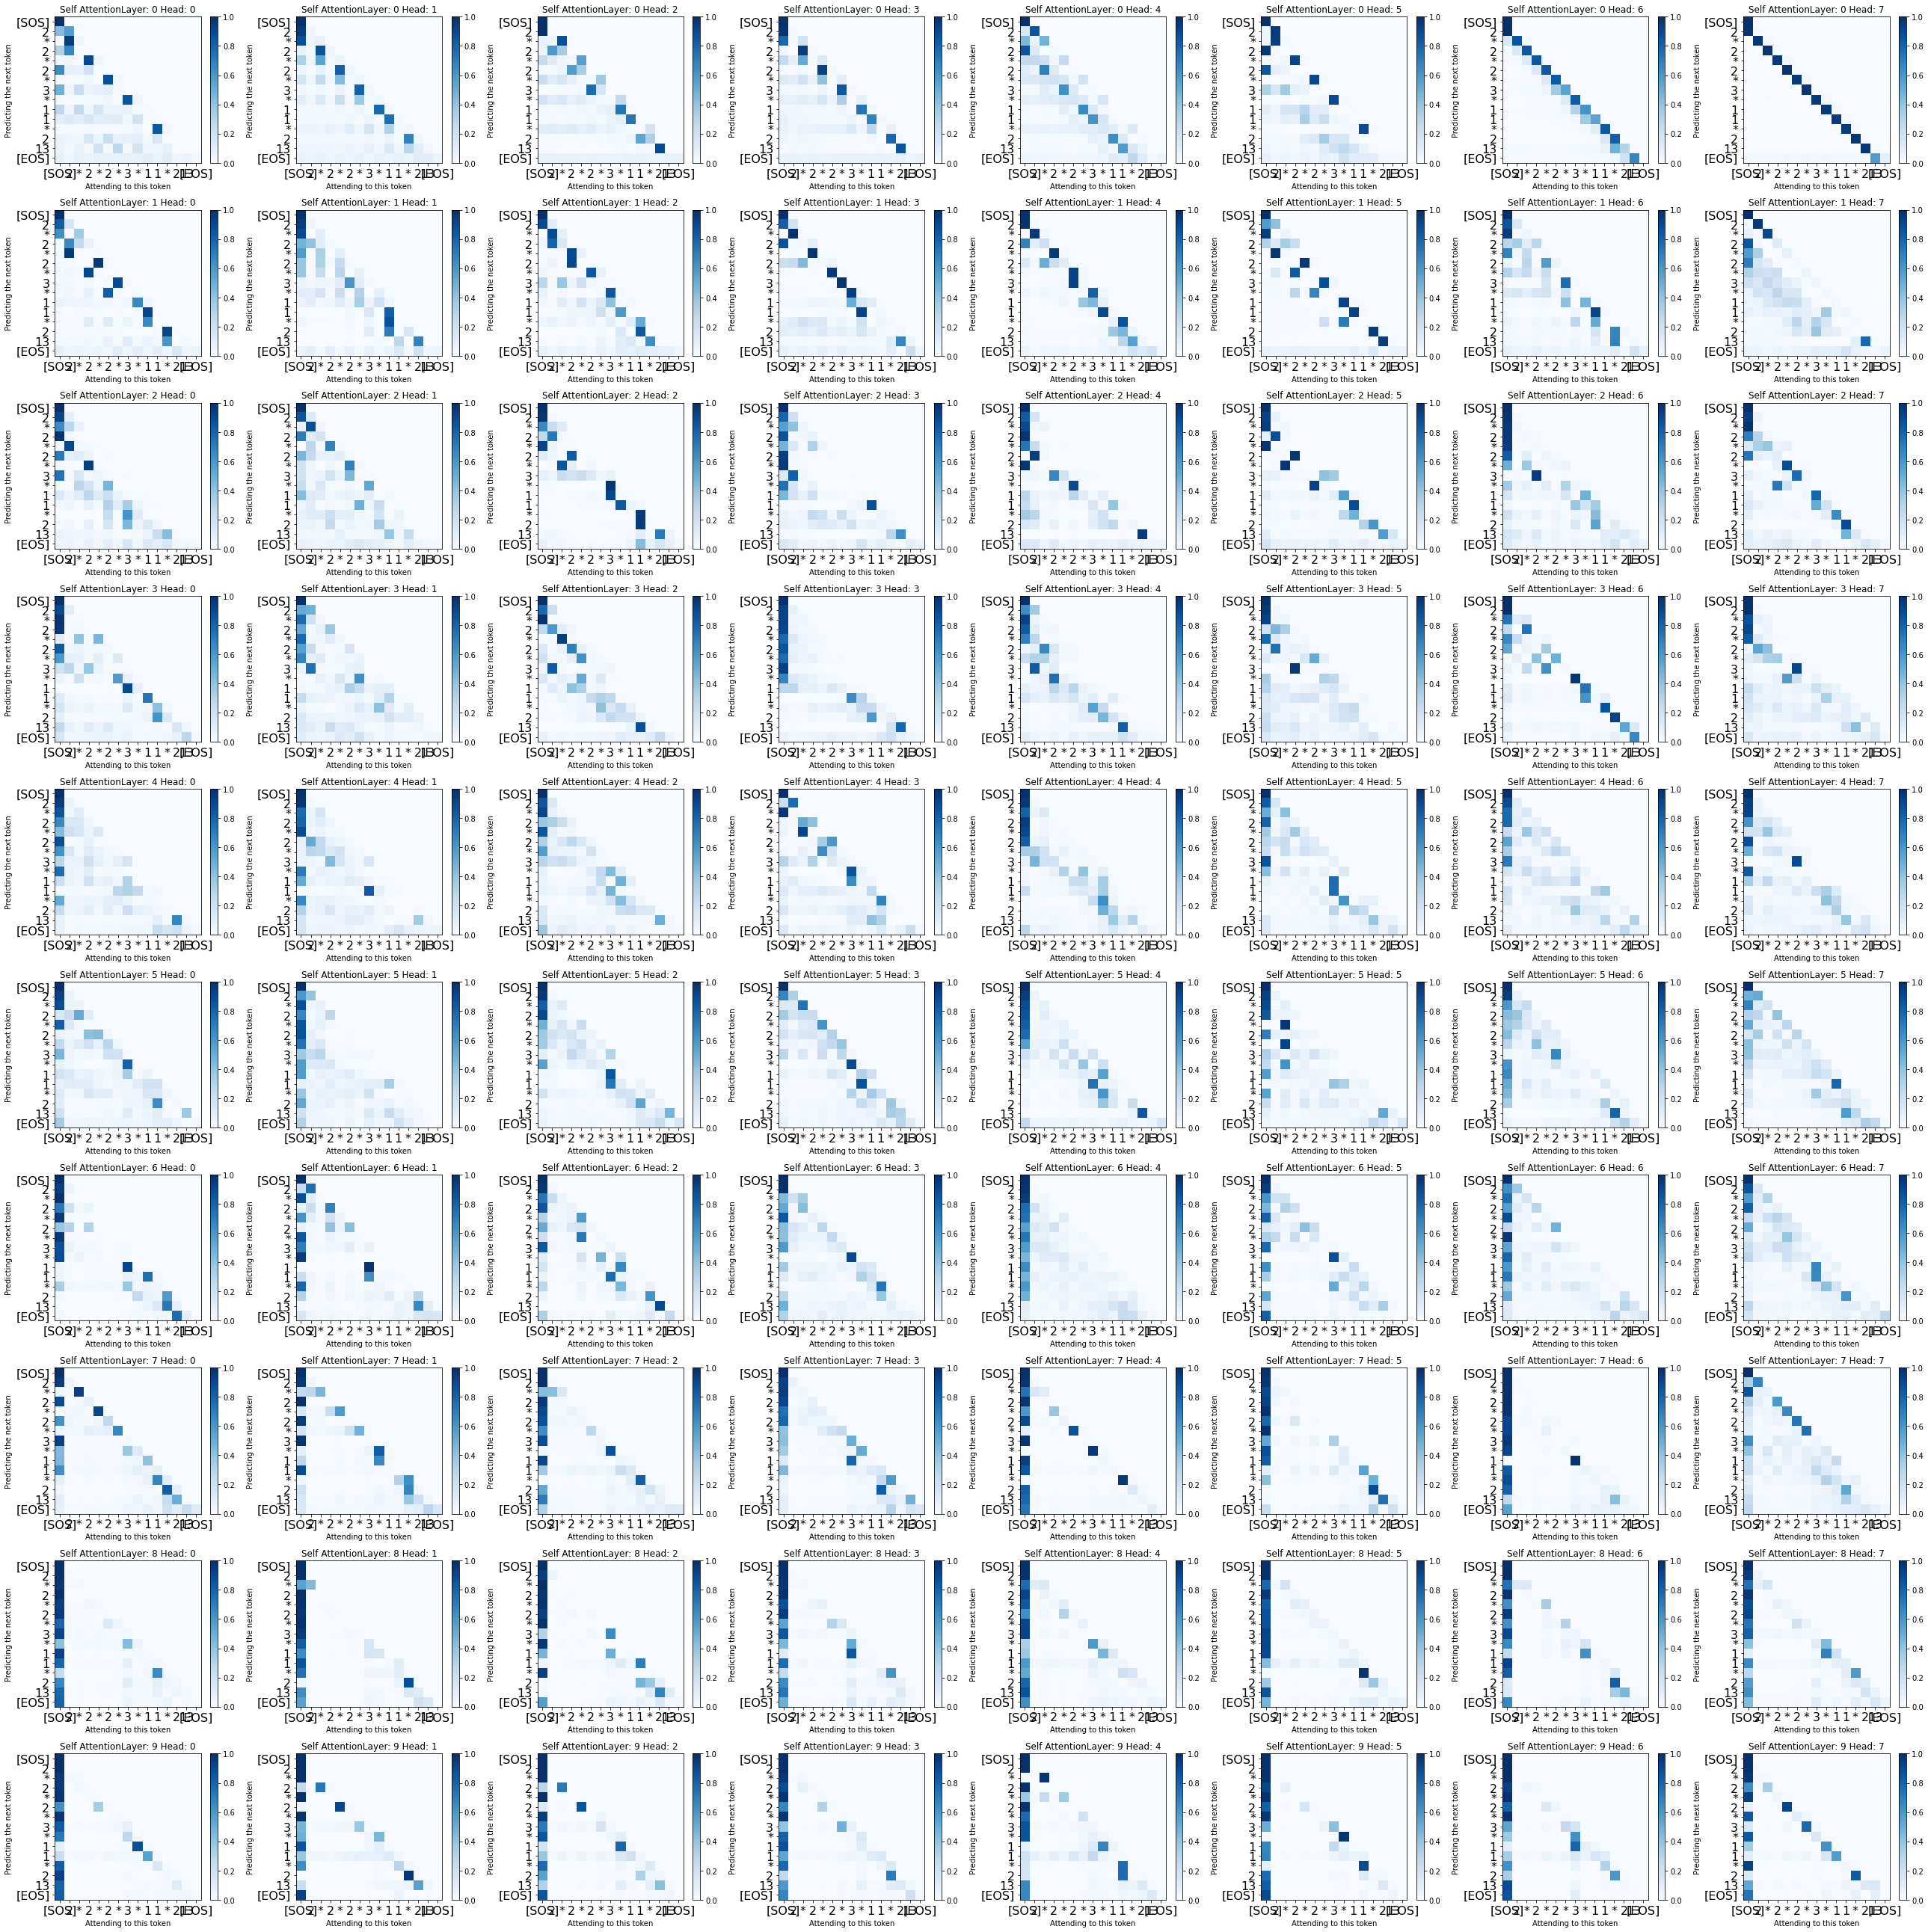

In [33]:
model_vis.visualize_attention(input, tgt, model, t, device)

In [28]:
input = torch.tensor(input).unsqueeze(0).to(device)
tgt = torch.tensor(tgt).unsqueeze(0).to(device)

In [20]:
input.size(), tgt.size()

(torch.Size([1, 6]), torch.Size([1, 15]))

In [21]:
with torch.no_grad():
    memory, memory_key_padding_mask = model.encode(input)

In [22]:
res, mem_attn, self_attn = model.decode(tgt, memory.repeat(1, tgt.size(0), 1), memory_key_padding_mask.repeat(tgt.size(0), 1), return_enc_dec_attn=True)

In [ ]:
# res: Batch size x # tokens in tgt x # possible tokens
# mem_attn: # layers x # heads x # tokens in tgt # num tokens in memory
# self_attn: # layers x # heads x # tokens in tgt x # tokens in tgt
res.size(), mem_attn.size(), self_attn.size()

In [ ]:
mem_label = t.decode(input[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')
tgt_label_attended_to = t.decode(tgt[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')
tgt_label_attended_for = t.decode(tgt[0].data.cpu().numpy().tolist(), decode_special=True).split(' ')

In [ ]:
mem_label

In [ ]:
tgt_label_attended_to

In [ ]:
tgt_label_attended_for

In [ ]:
import matplotlib as mpl
def show_attn(fig, ax, matrix, attn_type, title):
    ax.set_title(title)
    
    ax.set_ylabel('Predicting the next token')
    ax.set_xlabel('Attending to this token')
    
    if attn_type=='encoder_self':
        ax.set_yticks(np.arange(len(mem_label)))
        ax.set_yticklabels(labels=mem_label, fontsize=16)
        
        ax.set_xticks(np.arange(len(mem_label)))
        ax.set_xticklabels(labels=mem_label, fontsize=16)
    elif attn_type=='decoder_self':
        ax.set_yticks(np.arange(len(tgt_label_attended_for)))
        ax.set_yticklabels(labels=tgt_label_attended_for, fontsize=16)
        
        ax.set_xticks(np.arange(len(tgt_label_attended_to)))
        ax.set_xticklabels(labels=tgt_label_attended_to, fontsize=16)
    elif attn_type=='mem':
        ax.set_yticks(np.arange(len(tgt_label_attended_for)))
        ax.set_yticklabels(labels=tgt_label_attended_for, fontsize=16)
        
        ax.set_xticks(np.arange(len(mem_label)))
        ax.set_xticklabels(labels=mem_label, fontsize=16, rotation=90)
    else:
        raise ValueError(f'attn type {attn_type} not understood')

    
    
    im = ax.imshow(matrix, cmap='Blues')
    fig.colorbar(im, ax=ax)

    
#     if 'self' in attn_type:
#         fig.set_size_inches(7,7)
#     else:
#         fig.set_size_inches(4,7)

In [ ]:
fig, ax = plt.subplots(mem_attn.size(0), mem_attn.size(1))

for i in range(mem_attn.size(0)):
    for j in range(mem_attn.size(1)):
        title = '%s Layer: %d Head: %d'%('Mem', i,j)
        show_attn(fig, ax[i,j], mem_attn[i][j].data.cpu().numpy(), 'mem', title)
fig.set_size_inches(36,36)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(self_attn.size(0), self_attn.size(1))

for i in range(self_attn.size(0)):
    for j in range(self_attn.size(1)):
        title = '%s AttentionLayer: %d Head: %d'%('Self', i,j)
        show_attn(fig, ax[i,j], np.clip(self_attn[i][j].data.cpu().numpy(), a_min=0, a_max=.6), 'decoder_self', title)
fig.set_size_inches(36,36)
fig.tight_layout()